In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfinv
import scipy.integrate
from iminuit import Minuit

In [3]:
#Q1

#Open data file and read the lines into a list 
with open('datafile-higgs.txt') as f:
    lines = f.readlines()
    
masses = np.array(lines, dtype = float)         #Create an array from the list of masses
f.close()

In [4]:
print(len(masses))

100000


In [5]:
def run_minim(min_func):
    params = ['A','M','f']                        #set parameters to be calculated
    
    #Setting values to start at and estimated errors. 
    startvals = {params[0] : 5,params[1] : 2.5, params[2] : 0.98}           
    theMinuit = Minuit(min_func, **startvals)                 #run Minuit optimiser with with NLL function.
    theMinuit.errors=[0.1,0.1,0.1]                          #Errors on initial start value
    
    #Nll increases by 0.5 when you go to either side of the minimum by one unit error on the parameter
    theMinuit.errordef=0.5                        #Set errordef to 0.5 since this a log-likelihood function

    #Run the minimisation
    result = theMinuit.migrad()
    return params, theMinuit


In [6]:
#function which calculates the exp prob. density function normalised over [0,10].
def pdf_exp(A):
    return (1/(A*(np.exp(-0/A)-np.exp(-10/A))))*np.exp(-masses/A)   #pdf normalised over [0,10] with parameter A

#function which calculates the Gaussian prob. density function normalised over a fixed width of 0.2 sigma.
def pdf_Gaus(M): 
    sig = 0.2                                                              #Fixed width of Gaussian
    return (1/np.sqrt(2*np.pi*sig**2))*np.exp((-(masses-M)**2)/(2*sig**2)) #normalised Gaussian pdf

#function which calculates the negative log of the joint likelihood of the combined probability function.
#The parameters to be estimated are A (decay constant), M (the Gaussian mean), and f (fraction)

def NLLpdf(A, M,f):
    exp_fn = pdf_exp(A)    #call function which returns decay pdf
    Gaus_fn = pdf_Gaus(M)   #call function which returns Gaussian pdf
   
    return -np.sum(np.log((1-f)*Gaus_fn+(f)*exp_fn))  #return negative log of joint likelihood 
    


In [7]:
#call run_minim function with the parameter NLL 
#The function returns calculated parameters and corresponding errors.
params,theMinuit = run_minim(NLLpdf)
    
print ("\nMinuit Results for PDF (in microseconds)")

#Output results with errors rounded to 2 significant figures and values rounded to the same decimal places as the errors
print('\t','{:15s}'.format('A'), ':  \t', "{0:8.3f}".format(theMinuit.values[0]), ' +/- ', "{0:8.3f}".format(theMinuit.errors[0]))
print('\t','{:15s}'.format('M'), ':  \t', "{0:8.3f}".format(theMinuit.values[1]), ' +/- ', "{0:8.3f}".format(theMinuit.errors[1]))
print('\t','{:15s}'.format('f'), ':  \t', "{0:8.4f}".format(theMinuit.values[2]), ' +/- ', "{0:8.4f}".format(theMinuit.errors[2]))


Minuit Results for PDF (in microseconds)
	 A               :  	    5.008  +/-     0.031
	 M               :  	    2.499  +/-     0.015
	 f               :  	   0.9796  +/-    0.0012


As expected, the fitted mean, M, calculated agrees with the given M = 2.5 since the fitted value is within the statistical error.

In [7]:
#Code to plot pdf and fit line


def linefit(x,A,M,f):
    sig = 0.2
    exp_fn = (1/(A*(np.exp(-0/A)-np.exp(-10/A))))*np.exp(-x/A)   #call function which returns exp pdf
    Gaus_fn = (1/np.sqrt(2*np.pi*sig**2))*np.exp((-(x-M)**2)/(2*sig**2))  #call function which returns Gaussian pdf
                                                 
    return ((1-f)*Gaus_fn+f*exp_fn )
    

Text(0.5, 1.0, 'Combined Gaussian and exponential fits to masses')

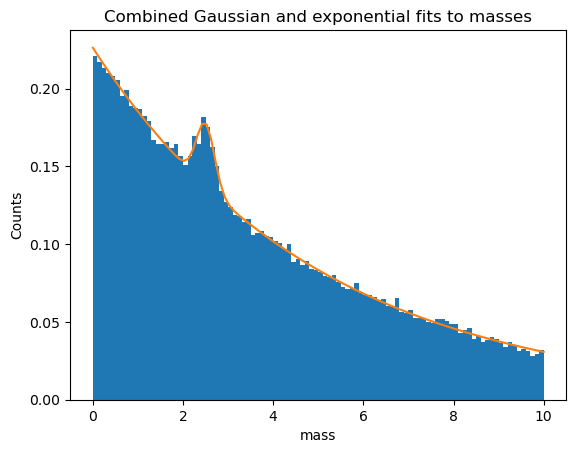

In [8]:
x = np.linspace(0,10,100)                                                       #Used as input for functions to fit curves
fit = linefit(x,theMinuit.values[0],theMinuit.values[1],theMinuit.values[2])    #Call fit function with fitted parameters

entries,counts, bins = plt.hist(masses,bins = 100,density = True)               #Plot masses pdf
plt.plot(x,fit)                                                                 #Plot fit line over pdf
plt.xlabel('mass')
plt.ylabel('Counts')
plt.title('Combined Gaussian and exponential fits to masses')


We observe that the fit line follows the distribution well.

In [9]:
#Q2

#minimiser function 
def run_minim_shift(min_func):
    params = ['b','c','M','f']                        #set parameters to be calculated
    
    #Setting values to start at and estimated errors. 
    startvals = {params[0] : -0.16,params[1] : 0.007, params[2] :2.5, params[3] : 0.98}           
    theMinuit = Minuit(NLLpdf_shift, **startvals)              #run Minuit optimiser with with NLL function.
    theMinuit.errors=[0.1,0.1,0.1,0.1]                          #Errors on initial start value
    
    #Nll increases by 0.5 when you go to either side of the minimum by one unit error on the parameter
    theMinuit.errordef=0.5                        #Set errordef to 0.5 since this a log-likelihood function

    #Run the minimisation
    result = theMinuit.migrad()
    return params, theMinuit

In [10]:
#function that returns second order polynomial 
def poly(masses,b,c):
    a=1
    return a+b*masses+c*masses**2  #pdf normalised over [0,10]

#function that returns normalised second order polynomial
def pdf_normed_poly(b,c):
    args = (b,c)
    integ = scipy.integrate.quad(poly,0,10,args = args)        #Integrate polynomial in interval [0,10] to get normalisation
    a=1
    return ((1/integ[0])*(a+b*masses+c*masses**2))

#function that returns the NLL of the combined polynomial and Gaussian pdfs
def NLLpdf_shift(b,c, M,f):
    poly_fn = pdf_normed_poly(b,c)   #call function which returns polynomial pdf
    Gaus_fn = pdf_Gaus(M)   #call function which returns Gaussian pdf
    
    
    #Set any values in polynomial and Gaussian functions that are negative to very small numbers. This is because we cannot
    #take the log of negative or 0 numbers
    poly_fn[poly_fn <= 0 ] = 1*10**(-15)
    Gaus_fn[Gaus_fn <= 0 ] = 1*10**(-15)
    NLL_comb = -np.sum(np.log((1-f)*Gaus_fn+(f)*poly_fn))
    
    return NLL_comb  #return negative log of joint likelihood 
    


In [11]:
#call run_minim function with the parameter NLL 
#The function returns calculated parameters and corresponding errors.
params_shift,theMinuit_shift = run_minim_shift(NLLpdf_shift)
    
print ("\nMinuit Results for PDF (in microseconds) with statistical errors from polynomial fit")

#Output results
print('\t','{:15s}'.format('b'), ':  \t', "{0:8.4f}".format(theMinuit_shift.values[0]), ' +/- ', "{0:8.4f}".format(theMinuit_shift.errors[0]))
print('\t','{:15s}'.format('c'), ':  \t', "{0:8.5f}".format(theMinuit_shift.values[1]), ' +/- ', "{0:8.5f}".format(theMinuit_shift.errors[1]))
print('\t','{:15s}'.format('M'), ':  \t', "{0:8.3f}".format(theMinuit_shift.values[2]), ' +/- ', "{0:8.3f}".format(theMinuit_shift.errors[2]))
print('\t','{:15s}'.format('f'), ':  \t', "{0:8.4f}".format(theMinuit_shift.values[3]), ' +/- ', "{0:8.4f}".format(theMinuit_shift.errors[3]))




Minuit Results for PDF (in microseconds) with statistical errors from polynomial fit
	 b               :  	  -0.1578  +/-    0.0014
	 c               :  	  0.00730  +/-   0.00015
	 M               :  	    2.494  +/-     0.016
	 f               :  	   0.9820  +/-    0.0012


In [12]:
#difference in the calculated parameter for the polynomial and exponential fits is taken as the systematic error
Err_sys = theMinuit_shift.values[2] - theMinuit.values[1]     
print('The systematic error on the mean of M due to the backround model is ',"{0:8.3f}".format(Err_sys))


The systematic error on the mean of M due to the backround model is    -0.004


In [13]:
M_error = np.sqrt((theMinuit.errors[1]**2 +Err_sys**2))     #add stat error and systematic error in quadrature
print('The total error on the mean', M_error) 

print('\t','{:15s}'.format('M (+/- stat error +/- sys error)'), ':  \t', "{0:8.3f}".format(theMinuit.values[1]), ' +/- ', "{0:8.3f}".format(theMinuit.errors[1]),' +/- ', "{0:8.3f}".format(abs(Err_sys)))
print('\t','{:15s}'.format('M (+/- total error)'), ':  \t', "{0:8.3f}".format(theMinuit.values[1]),' +/- ',"{0:8.3f}".format( M_error))

The total error on the mean 0.015184198485872795
	 M (+/- stat error +/- sys error) :  	    2.499  +/-     0.015  +/-     0.004
	 M (+/- total error) :  	    2.499  +/-     0.015


The systematic error is significantly less than the statistical error. When rounded to 2 significant figures, the combined error
between the system and statistical errors is the same as the just the statistical error. We can conclude that the systematic error is not important in this measurement.

In [14]:
#Plots

def polyfit(x,b,c):
    a=1
    return a+b*x+c*x**2  #pdf normalised over [0,10]

def pdf_normed_poly(b,c):
    args = (b,c)
    integ = scipy.integrate.quad(polyfit,0,10,args = args)
    a=1
    return ((1/integ[0])*(a+b*x+c*x**2))

In [15]:
def linefit2(x,b,c,M,f):
    sig = 0.2
    poly_fn = pdf_normed_poly(b,c)   #call function which returns polynomial pdf
   
    Gaus_fn = (1/np.sqrt(2*np.pi*sig**2))*np.exp((-(x-M)**2)/(2*sig**2))  #call function which returns Gaussian pdf
                                                 
    return ((1-f)*Gaus_fn+f*poly_fn )

Text(0.5, 1.0, 'Combined Gaussian and polynomial fits to masses')

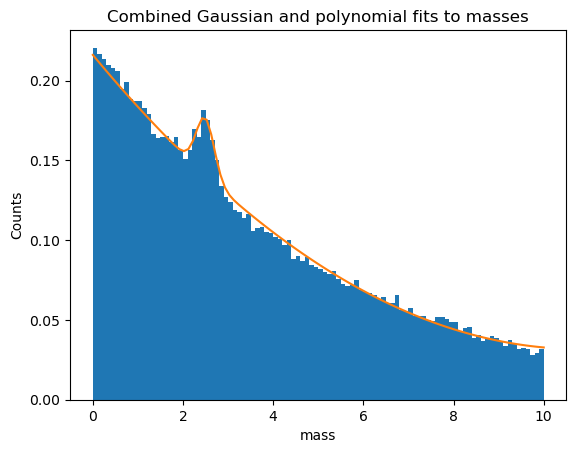

In [16]:

fit2 = linefit2(x,theMinuit_shift.values[0],theMinuit_shift.values[1],theMinuit_shift.values[2],theMinuit_shift.values[3])

entries,counts, bins = plt.hist(masses,bins = 100,density = True)
plt.plot(x,fit2)
plt.xlabel('mass')
plt.ylabel('Counts')
plt.title('Combined Gaussian and polynomial fits to masses')

This fit approximately follows the distribution. It appears to be more accuracte than the linear+Gaussian fit but less accurate than the expeonential+Gaussian fit.

In [17]:
#Q3

def run_minim_shiftlinear(min_func):
    params = ['b','M','f']                        #set parameters to be calculated
    #Setting values to start at and estimated errors. 
    startvals = {params[0] : -0.09,params[1] : 2.5, params[2] :0.98}           
    theMinuit = Minuit(NLLpdf_shiftlinear, **startvals)              #run Minuit optimiser with with NLL function.
    theMinuit.errors=[0.1,0.1,0.1]                          #Errors on initial start value
    
    #Nll increases by 0.5 when you go to either side of the minimum by one unit error on the parameter
    theMinuit.errordef=0.5                        #Set errordef to 0.5 since this a log-likelihood function

    #Run the minimisation
    result = theMinuit.migrad()
    return params, theMinuit

In [18]:
#Function to leturn linear curve
def linear(masses,b):
    a=1
    return a + b*masses 

#function to return normalised linear curve
def pdf_normed_linear(b):
    args = (b,)
    integ = scipy.integrate.quad(linear,0,10,args = args) #integrate linear curve between [0,10] to get normalisation
    a=1
    return ((1/integ[0])*(a+b*masses))

#Function to calculate combined NLL with linear and Gaussian pdfs
def NLLpdf_shiftlinear(b,M,f):
    linear_fn = pdf_normed_linear(b)   #call function which returns linear pdf
    Gaus_fn = pdf_Gaus(M)   #call function which returns Gaussian pdf
    
    linear_fn[linear_fn < 0 ] = 1*10**(-15)
    Gaus_fn[Gaus_fn < 0 ] = 1*10**(-15)
    NLL_comblinear = -np.sum(np.log((1-f)*Gaus_fn+(f)*linear_fn))
    
    return NLL_comblinear  #return negative log of joint likelihood 
    



In [19]:
#call run_minim function with the parameter NLL 
#The function returns calculated parameters and corresponding errors.
params_shiftlinear,theMinuit_shiftlinear = run_minim_shiftlinear(NLLpdf_shiftlinear)
    

#Output results
print('\t','{:15s}'.format('b'), ':  \t', "{0:8.5f}".format(theMinuit_shiftlinear.values[0]), ' +/- ', "{0:8.5f}".format(theMinuit_shiftlinear.errors[0]))
print('\t','{:15s}'.format('M'), ':  \t', "{0:8.3f}".format(theMinuit_shiftlinear.values[1]), ' +/- ', "{0:8.3f}".format(theMinuit_shiftlinear.errors[1]))
print('\t','{:15s}'.format('f'), ':  \t', "{0:8.4f}".format(theMinuit_shiftlinear.values[2]), ' +/- ', "{0:8.4f}".format(theMinuit_shiftlinear.errors[2]))



	 b               :  	 -0.09040  +/-   0.00022
	 M               :  	    2.465  +/-     0.015
	 f               :  	   0.9801  +/-    0.0012


In [20]:
#Plots

def linearfit(x,b):
    a=1
    return a+b*x  #pdf normalised over [0,10]

def pdf_normed_linear(b,):
    args = (b,)
    integ = scipy.integrate.quad(linearfit,0,10,args = args)
    a=1
    return (1/integ[0])*(a+b*x)

In [21]:
def linefit3(x,b,M,f):
    sig = 0.2
    linear_fn = pdf_normed_linear(b)   #call function which returns decay pdf
   
    Gaus_fn = (1/np.sqrt(2*np.pi*sig**2))*np.exp((-(x-M)**2)/(2*sig**2))  #call function which returns Gaussian pdf
                                                 
    return ((1-f)*Gaus_fn+f*linear_fn )

Text(0.5, 1.0, 'Combined Gaussian and polynomial fits to masses')

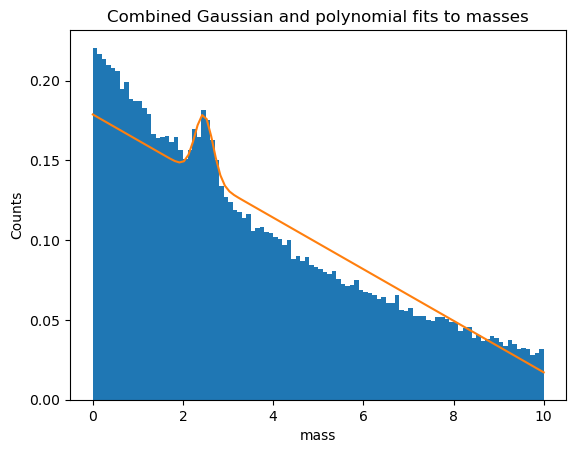

In [22]:

fit3 = linefit3(x,theMinuit_shiftlinear.values[0],theMinuit_shiftlinear.values[1],theMinuit_shiftlinear.values[2])

entries,counts, bins = plt.hist(masses,bins = 100,density = True)
plt.plot(x,fit3)
plt.xlabel('mass')
plt.ylabel('Counts')
plt.title('Combined Gaussian and polynomial fits to masses')

By observation this combined linear Gaussian fit is the worst fit; it does not follow the distribution very well.

In [23]:
#Calculate difference between fitted mean for the linear + Gaussian and fitted mean for exponential model
Err_sys_linear = theMinuit_shiftlinear.values[1] - theMinuit.values[1]  
print('The difference between the linear fitted mean and exponential fitted mean of M is ',"{0:8.3f}".format(abs(Err_sys_linear)))

#calculate difference in fitted mean for linear and polynomial models
Err_sys_linearpoly = theMinuit_shiftlinear.values[1] - theMinuit_shift.values[2]

#Calculate which of the three fitted means have the largest difference and set this as the total systematic error
max_sys_err = (max(abs(Err_sys_linear),abs(Err_sys),abs(Err_sys_linearpoly)))
 

M_error = np.sqrt((theMinuit.errors[1]**2 +max_sys_err**2))  #add systematic and statistical errors in quadrature


print('Total error on the mean is',"{0:8.3f}".format( M_error))

The difference between the linear fitted mean and exponential fitted mean of M is     0.033
Total error on the mean is    0.036


In [24]:
print('\t','{:15s}'.format('M (+/- stat error +/- sys error)'), ':  \t', "{0:8.3f}".format(theMinuit.values[1]), ' +/- ', "{0:8.3f}".format(theMinuit.errors[1]), ' +/- ', "{0:8.3f}".format(max_sys_err))
print('\t','{:15s}'.format('M (+/- total error)'), ':  \t', "{0:8.3f}".format(theMinuit.values[1]),' +/- ',"{0:8.3f}".format( M_error))

	 M (+/- stat error +/- sys error) :  	    2.499  +/-     0.015  +/-     0.033
	 M (+/- total error) :  	    2.499  +/-     0.036


In this case the systematic error is slighty greater than double the statistical error. Therefore, it is clear that the systematic error is important in this case. When rounded to 2 significant figures we see that the total error is signficantly larger than just the statistical error.